In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import numpy  as np
import pandas as pd
import random

from sklearn import datasets
from scipy.spatial.distance import cdist #считает пространственную 

#Инициализируем датасет


In [2]:
iris = datasets.load_iris()
trainX = iris.data
trainY = iris.target

In [3]:
testX = []
testY = []

#забираем 15 штук на валидацию, выбрал рандомно
indexes = [42, 25, 98, 50, 136, 113, 90, 118, 7, 81, 114, 128, 46, 103, 63]

for index in indexes:
  testX.append(np.array(trainX[index]))
  testY.append(np.array(trainY[index]))

trainX = np.delete(trainX, indexes, axis=0)
trainY = np.delete(trainY, indexes, axis=0)

In [4]:
testX = np.array(testX)
testY = np.array(testY)

#Визуализируем данные

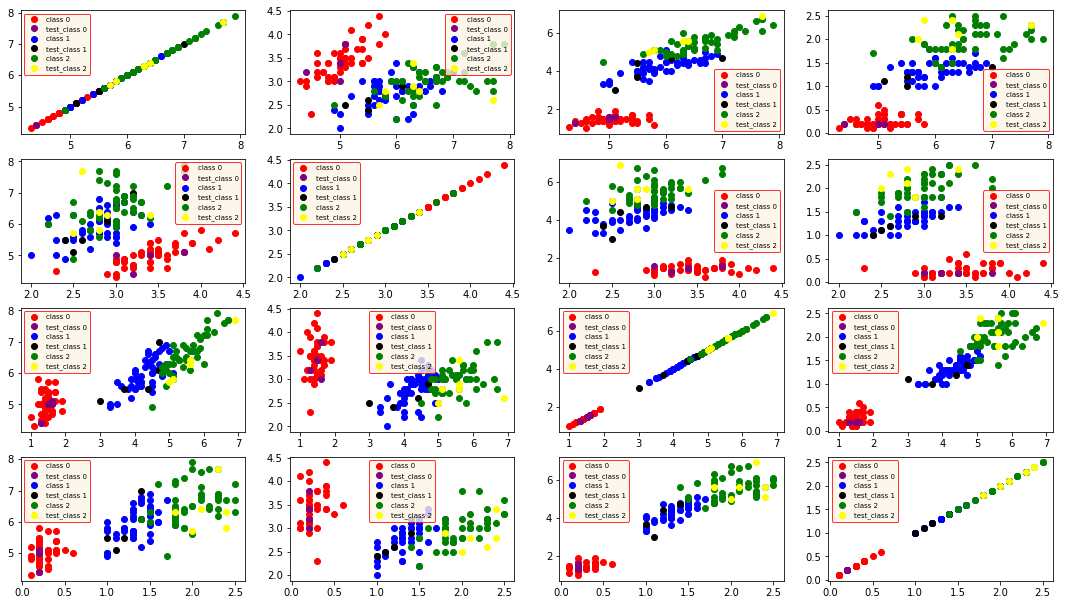

In [5]:
fig, axs = plt.subplots(nrows=4, ncols=4)

colors = ['red', 'blue', 'green']
test_colors = ['purple', 'black', 'yellow']

for i in range(4):
    for j in range(4):
        for k in np.unique(trainY):
            axs[i%4, j%4].plot(trainX[trainY==k, i], trainX[trainY==k, j], 'o', label='class {}'.format(k), color = colors[k])
            axs[i%4, j%4].plot(testX[testY==k, i], testX[testY==k, j], 'o', label='test_class {}'.format(k), color = test_colors[k])
            axs[i%4, j%4].legend(fontsize=7, ncol=1, facecolor='oldlace', edgecolor='r')

fig.set_size_inches(18.5, 10.5)
plt.show()
plt.close()

#Ядра


In [6]:
def K(distance, h=0.05):
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1)

In [7]:
def K1(distance, h=0.05):
    ret = np.array(distance)/h
    return (1./(ret + 1.)) * (np.abs(ret) <= 1)

In [8]:
def K_exp(distance, h=0.05):
    ret = np.array(distance)/h
    return np.exp(ret) * (np.abs(ret) <= 1)

In [9]:
def Kn(distance, h=0.05, d=1):
    ret = np.array(distance)/h
    return (ret + 1.)**d * (np.abs(ret) <= 1)

In [10]:
def Ksigmoid(distance, h=0.05, r=1):
    ret = np.array(distance)/h
    return np.tanh(ret + 1) * (np.abs(ret) <= 1)

In [13]:
def calc_accuracy(model, X, Y) -> float:
    counter = 0

    for i, (x, y) in enumerate(zip(testX, testY)):
        prediction = model.predict(np.array([x]))[0]
        if prediction == y:
            counter += 1

    print(f'Accuracy on test with h={h}:   {counter/len(testX)}')
    return counter/len(testX)

In [14]:
def calc_accuracy_with_predictions(model, X, Y):
    counter = 0

    for i, (x, y) in enumerate(zip(testX, testY)):
        prediction = model.predict(np.array([x]))[0]
        print(f'predict: {prediction} \t ground t: {testY[i]}')
        if prediction == y:
            counter += 1

    print(f'Accuracy on test:   {counter/len(testX)}')

#Метод потенциальных функций с ядром

In [109]:
from scipy.spatial import distance
class PFM(object):
 
    def __init__(self, kernel=None)->None:
        self.X, self.Y, self.gams = None, None, None
        self.kernel = lambda x: np.ones_like(x)
        if kernel is not None:
            self.kernel = kernel

    def get_gams(self) -> np.array:
        if self.gams is None:
            return np.ones_like(self.X)
        else:
            return self.gams

    def _calc_distances(self, XA, XB) -> np.array:
        """
        размер массива расстояний: если в XA - n строк, а в XB m строк -> (n, m)
        """
        distance = np.sqrt(np.sum((XA.T - XB.T)**2, axis=0))
        # print(XA.shape, XB.shape)
        return np.array(distance)

    def _scores(self, features):
        scores = np.vstack(
            [np.sum(features.T[np.where(self.Y==0)[0]].T, axis=-1),
            np.sum(features.T[np.where(self.Y==1)[0]].T, axis=-1),
            np.sum(features.T[np.where(self.Y==2)[0]].T, axis=-1)]).T
        return scores


    def scores(self, X) -> np.array:
        # features = self.gams * self.kernel(cdist(X, self.X))
        features = self.gams * self.kernel(self._calc_distances(XA=X, XB=self.X))
        scores = np.vstack(
            [np.sum(features.T[np.where(self.Y==0)[0]].T, axis=-1),
            np.sum(features.T[np.where(self.Y==1)[0]].T, axis=-1),
            np.sum(features.T[np.where(self.Y==2)[0]].T, axis=-1)]).T
        return scores

    def predict(self, X):
        return np.argmax(self.scores(X), axis=-1)

    def fit(self, X: np.array, Y: np.array, epochs: int) -> None:
        self.X, self.Y, self.gams = np.array(X), np.array(Y), np.zeros(len(Y))
        # print(f'initial gams:{self.gams}')
        for epoch in range(epochs):
            prediction = np.zeros_like(self.Y)
            features = np.expand_dims(self.gams, axis=0) * self.kernel(np.sqrt(np.sum((np.expand_dims(X, axis=1)-np.expand_dims(X, axis=0))**2, axis=2)))
            scores = self._scores(features)
            prediction += np.argmax(scores, axis=0)[0]
            self.gams[np.where(prediction!= self.Y)[0]] += 1

             # prediction = np.array([self.predict(np.array([x])) for x in self.X]).T

    def increment_gams(self, x):
        self.gams += 1

    def fit_non_zero(self, X: np.array, Y: np.array, epochs: int, starter: int)->None:

        self.X, self.Y, self.gams = X, Y, np.zeros_like(Y) + starter
        
        for _ in range(epochs):
            predictions = np.array([self.predict(np.array([x])) for x in self.X]).T
            self.gams[np.where(predictions[0] != self.Y)[0]] += 1

    def increase_gams(self, increaser: int):
        self.gams += increaser

#Тренируем модель

**с ядром**

In [112]:
model = PFM(kernel=lambda x: K1(x, h=.9))
model.fit(trainX, trainY,100)
calc_accuracy_with_predictions(model=model, X=testX, Y=testY)
print(model.gams)

predict: 2 	 ground t: 2
predict: 2 	 ground t: 2
predict: 2 	 ground t: 2
predict: 1 	 ground t: 1
predict: 1 	 ground t: 1
predict: 0 	 ground t: 0
predict: 1 	 ground t: 1
predict: 1 	 ground t: 2
predict: 2 	 ground t: 2
predict: 1 	 ground t: 1
predict: 2 	 ground t: 2
predict: 1 	 ground t: 1
predict: 1 	 ground t: 1
predict: 0 	 ground t: 0
predict: 1 	 ground t: 1
Accuracy on test:   0.9333333333333333
[100. 100. 100. 100. 100. 100. 100. 100.   0. 100. 100. 100.   0. 100.
 100.   0.   0. 100.   0. 100. 100.   0. 100. 100. 100. 100. 100. 100.
 100.   0. 100. 100.   0.   0. 100. 100. 100. 100.   0. 100. 100.   0.
 100. 100.   0.   0.   0.   0. 100. 100.   0. 100.   0.   0.   0.   0.
 100. 100. 100. 100. 100. 100. 100. 100. 100.   0. 100. 100.   0.   0.
   0. 100.   0. 100. 100.   0. 100. 100. 100. 100. 100. 100. 100. 100.
   0.   0.   0. 100. 100.   0.   0. 100. 100. 100.   0.   0.   0.   0.
   0. 100.   0. 100. 100. 100.   0. 100. 100. 100. 100. 100.   0.   0.
   0.   0. 100.   

Accuracy on test with h=0.05:   0.13333333333333333
Accuracy on test with h=0.1:   0.13333333333333333
Accuracy on test with h=0.5:   0.8
Accuracy on test with h=1.0:   0.9333333333333333
Accuracy on test with h=2.0:   0.9333333333333333
Accuracy on test with h=10.0:   0.8666666666666667


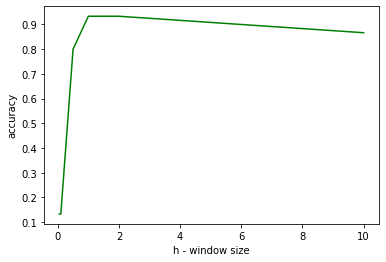

In [36]:
accuracy_val = []
h_val = [0.05, 0.1, 0.5, 1.0, 2.0, 10.0]
for h in [0.05, 0.1, 0.5, 1.0, 2.0, 10.0]:
    model = PFM(kernel=lambda x: K1(x, h=h))
    model.fit(trainX, trainY, 100)
    accuracy_val.append(calc_accuracy(model=model, X=testX, Y=testY))

plt.plot(h_val, accuracy_val, label='accuracy', color='green')
plt.xlabel('h - window size')
plt.ylabel('accuracy')
plt.show()
plt.close()

#Кроссвалидация


In [19]:
iris = datasets.load_iris()
x = np.array(iris.data)
y = np.array(iris.target)
trainY, trainX = [], []

indexes = np.random.permutation(len(y))

for i in range(len(y)):
    trainY.append(y[indexes[i]])
    trainX.append(x[indexes[i]])

trainX = np.array(trainX)
trainY = np.array(trainY)

In [22]:
K=5  # кол-во подвыборок
# print(len(y))

for h in [0.05, 0.1, 0.35, .55, 1.0, 3.0]:
    print(f'h={h}: \n')
    X = np.array_split(trainX, K, axis=0)
    Y = np.array_split(trainY, K, axis=0)

    accuracy_counter = 0

    for k in range(K):
        print(f'k={k}')
        subX, subY = None, None
        for i in range(K):
            if i != k:
                if subX is not None:
                    subX = np.vstack([subX, X[i]])
                else:
                    subX = X[i]
                if subY is not None:
                    subY = np.hstack([subY, Y[i]])
                else:
                    subY = Y[i]
                # print(subY)

        model = PFM(kernel=lambda x: K_exp(x, h=h))
        model.fit(subX, subY, 50)
        accuracy_counter += calc_accuracy(model=model, X=X[i], Y=Y[i])
    print(f'average accuracy = {accuracy_counter/K}\n\n')


h=0.05: 

k=0
Accuracy on test with h=0.05:   0.8666666666666667
k=1
Accuracy on test with h=0.05:   0.8666666666666667
k=2
Accuracy on test with h=0.05:   0.8
k=3
Accuracy on test with h=0.05:   0.8666666666666667
k=4
Accuracy on test with h=0.05:   0.8666666666666667
average accuracy = 0.8533333333333333


h=0.1: 

k=0
Accuracy on test with h=0.1:   0.8666666666666667
k=1
Accuracy on test with h=0.1:   0.8666666666666667
k=2
Accuracy on test with h=0.1:   0.8
k=3
Accuracy on test with h=0.1:   0.8666666666666667
k=4
Accuracy on test with h=0.1:   0.8666666666666667
average accuracy = 0.8533333333333333


h=0.35: 

k=0
Accuracy on test with h=0.35:   1.0
k=1
Accuracy on test with h=0.35:   0.9333333333333333
k=2
Accuracy on test with h=0.35:   1.0
k=3
Accuracy on test with h=0.35:   0.9333333333333333
k=4
Accuracy on test with h=0.35:   0.9333333333333333
average accuracy = 0.9600000000000002


h=0.55: 

k=0
Accuracy on test with h=0.55:   0.9333333333333333
k=1
Accuracy on test with 

In [23]:
model.gams

array([50., 50.,  1., 49., 50., 50., 50., 50.,  1., 49., 50., 49., 50.,
       50.,  1.,  3., 50.,  2., 50., 49., 49., 50.,  2., 50., 49., 49.,
       49., 50., 49., 49., 50.,  1., 49., 50., 50.,  1.,  1., 50., 50.,
       50., 49., 49., 50.,  1., 50., 50., 49., 50., 50., 50., 50.,  2.,
        1.,  1., 48., 49., 50., 50.,  1.,  1., 50., 49.,  1., 49.,  1.,
       50., 49.,  1., 22., 50., 49., 50., 49., 50., 50.,  1., 50.,  2.,
        1., 50.,  5.,  1.,  3.,  1., 16., 49.,  1., 50., 48., 49.,  1.,
       49., 49., 50.,  2., 49., 48., 50., 49.,  1., 50.,  1., 50.,  1.,
       50., 49., 50., 50., 25., 50., 49., 50.,  2.,  1., 50., 50.,  1.,
       49., 50., 50.])

**Показать элементы с ненулевым потенциалом**

In [24]:
iris = datasets.load_iris()
x = np.array(iris.data)
y = np.array(iris.target)
trainY, trainX = [], []

indexes = np.random.permutation(len(y))

for i in range(len(y)):
    trainY.append(y[indexes[i]])
    trainX.append(x[indexes[i]])

trainX = np.array(trainX)
trainY = np.array(trainY)

spliter = round(len(trainX)*0.1)

testX = trainX[:spliter]
testY = trainY[:spliter]
trainX = trainX[spliter:]
trainY = trainY[spliter:]

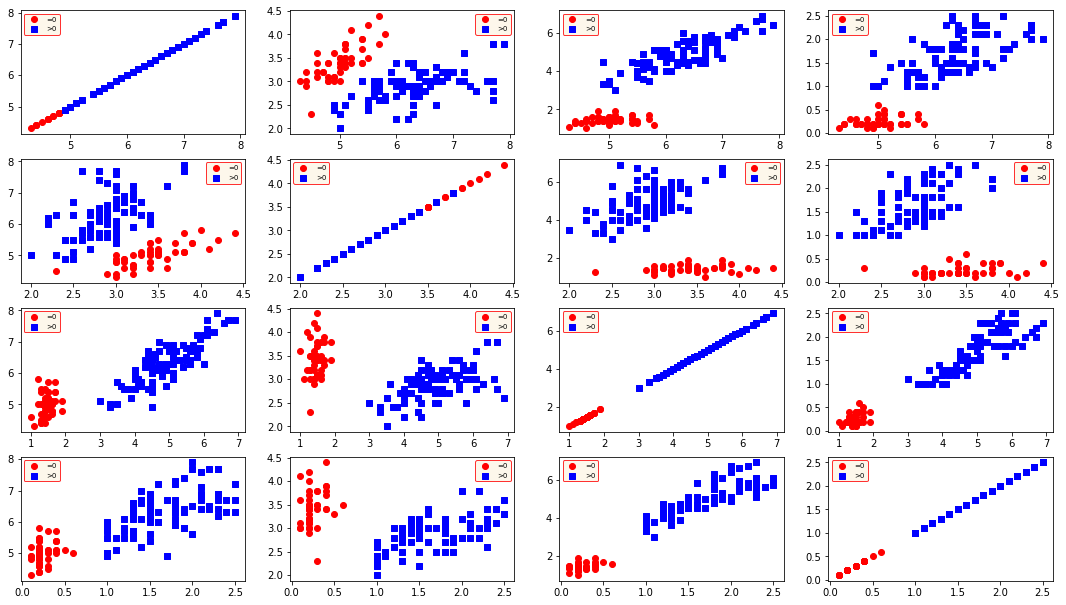

In [113]:
model = PFM(kernel=lambda x: K_exp(x, h=0.35))
model.fit(trainX, trainY, 10)

fig, axs = plt.subplots(nrows=4, ncols=4)

colors = ['red', 'blue', 'green']
test_colors = ['purple', 'black', 'yellow']

gams = model.gams

for i in range(4):
    for j in range(4):
            axs[i%4, j%4].scatter(trainX[np.where(gams== 0)[0], i], trainX[np.where(gams== 0)[0], j], color = colors[0], label='=0')
            axs[i%4, j%4].scatter(trainX[np.where(gams!= 0)[0], i], trainX[np.where(gams!= 0)[0], j], color = colors[1], label='>0', marker='s')
            axs[i%4, j%4].legend(fontsize=7, ncol=1, facecolor='oldlace', edgecolor='r')
fig.set_size_inches(18.5, 10.5)
plt.show()
plt.close()

##Что если после обучения увеличить потенциал? сделать ненулевым

In [114]:
print(model.gams)

[10. 10. 10. 10. 10. 10. 10. 10.  0. 10. 10. 10.  0. 10. 10.  0.  0. 10.
  0. 10. 10.  0. 10. 10. 10. 10. 10. 10. 10.  0. 10. 10.  0.  0. 10. 10.
 10. 10.  0. 10. 10.  0. 10. 10.  0.  0.  0.  0. 10. 10.  0. 10.  0.  0.
  0.  0. 10. 10. 10. 10. 10. 10. 10. 10. 10.  0. 10. 10.  0.  0.  0. 10.
  0. 10. 10.  0. 10. 10. 10. 10. 10. 10. 10. 10.  0.  0.  0. 10. 10.  0.
  0. 10. 10. 10.  0.  0.  0.  0.  0. 10.  0. 10. 10. 10.  0. 10. 10. 10.
 10. 10.  0.  0.  0.  0. 10.  0. 10.  0.  0. 10. 10. 10. 10. 10. 10.  0.
 10. 10. 10. 10.  0. 10. 10.  0. 10.]


predict: 2 	 ground t: 2
predict: 2 	 ground t: 2
predict: 2 	 ground t: 2
predict: 1 	 ground t: 1
predict: 1 	 ground t: 1
predict: 0 	 ground t: 0
predict: 1 	 ground t: 1
predict: 1 	 ground t: 2
predict: 2 	 ground t: 2
predict: 1 	 ground t: 1
predict: 2 	 ground t: 2
predict: 1 	 ground t: 1
predict: 1 	 ground t: 1
predict: 0 	 ground t: 0
predict: 1 	 ground t: 1
Accuracy on test:   0.9333333333333333
[100. 100. 100. 100. 100. 100. 100. 100.   0. 100. 100. 100.   0. 100.
 100.   0.   0. 100.   0. 100. 100.   0. 100. 100. 100. 100. 100. 100.
 100.   0. 100. 100.   0.   0. 100. 100. 100. 100.   0. 100. 100.   0.
 100. 100.   0.   0.   0.   0. 100. 100.   0. 100.   0.   0.   0.   0.
 100. 100. 100. 100. 100. 100. 100. 100. 100.   0. 100. 100.   0.   0.
   0. 100.   0. 100. 100.   0. 100. 100. 100. 100. 100. 100. 100. 100.
   0.   0.   0. 100. 100.   0.   0. 100. 100. 100.   0.   0.   0.   0.
   0. 100.   0. 100. 100. 100.   0. 100. 100. 100. 100. 100.   0.   0.
   0.   0. 100.   

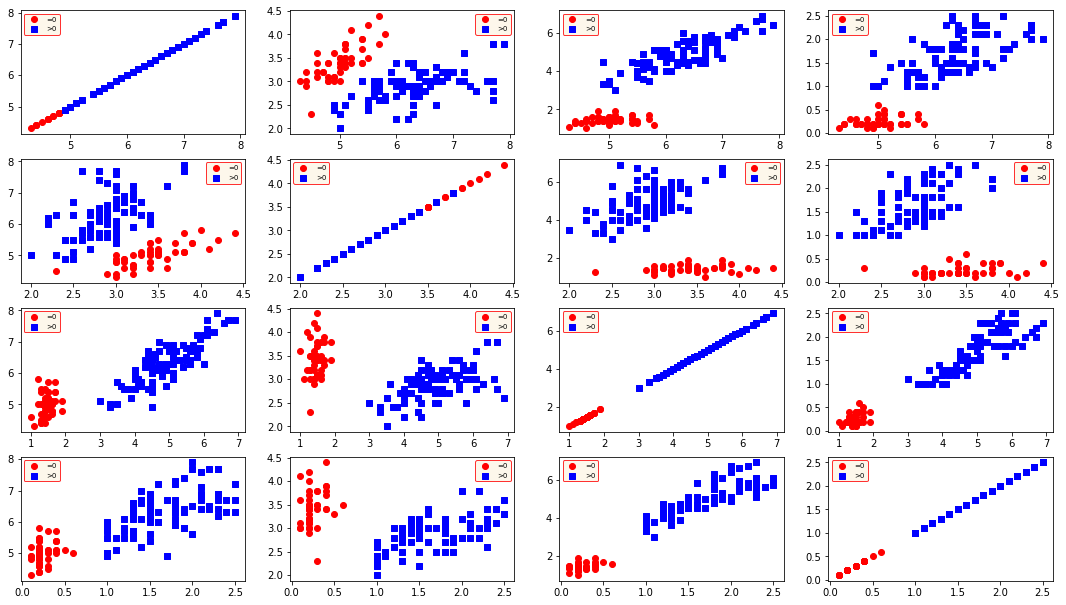

In [124]:
model = PFM(kernel=lambda x: K1(x, h=0.9))

model.fit(trainX, trainY, 100)
calc_accuracy_with_predictions(model=model, X=testX, Y=testY)
print(model.gams)

fig, axs = plt.subplots(nrows=4, ncols=4)

colors = ['red', 'blue', 'green']
test_colors = ['purple', 'black', 'yellow']

gams = model.gams

for i in range(4):
    for j in range(4):
            axs[i%4, j%4].scatter(trainX[np.where(gams== 0)[0], i], trainX[np.where(gams== 0)[0], j], color = colors[0], label='=0')
            axs[i%4, j%4].scatter(trainX[np.where(gams!= 0)[0], i], trainX[np.where(gams!= 0)[0], j], color = colors[1], label='>0', marker='s')
            axs[i%4, j%4].legend(fontsize=7, ncol=1, facecolor='oldlace', edgecolor='r')
fig.set_size_inches(18.5, 10.5)
plt.show()
plt.close()

[101. 101. 101. 101. 101. 101. 101. 101.   1. 101. 101. 101.   1. 101.
 101.   1.   1. 101.   1. 101. 101.   1. 101. 101. 101. 101. 101. 101.
 101.   1. 101. 101.   1.   1. 101. 101. 101. 101.   1. 101. 101.   1.
 101. 101.   1.   1.   1.   1. 101. 101.   1. 101.   1.   1.   1.   1.
 101. 101. 101. 101. 101. 101. 101. 101. 101.   1. 101. 101.   1.   1.
   1. 101.   1. 101. 101.   1. 101. 101. 101. 101. 101. 101. 101. 101.
   1.   1.   1. 101. 101.   1.   1. 101. 101. 101.   1.   1.   1.   1.
   1. 101.   1. 101. 101. 101.   1. 101. 101. 101. 101. 101.   1.   1.
   1.   1. 101.   1. 101.   1.   1. 101. 101. 101. 101. 101. 101.   1.
 101. 101. 101. 101.   1. 101. 101.   1. 101.]
predict: 2 	 ground t: 2
predict: 2 	 ground t: 2
predict: 2 	 ground t: 2
predict: 1 	 ground t: 1
predict: 1 	 ground t: 1
predict: 0 	 ground t: 0
predict: 1 	 ground t: 1
predict: 1 	 ground t: 2
predict: 2 	 ground t: 2
predict: 1 	 ground t: 1
predict: 2 	 ground t: 2
predict: 1 	 ground t: 1
predict: 1 	 g

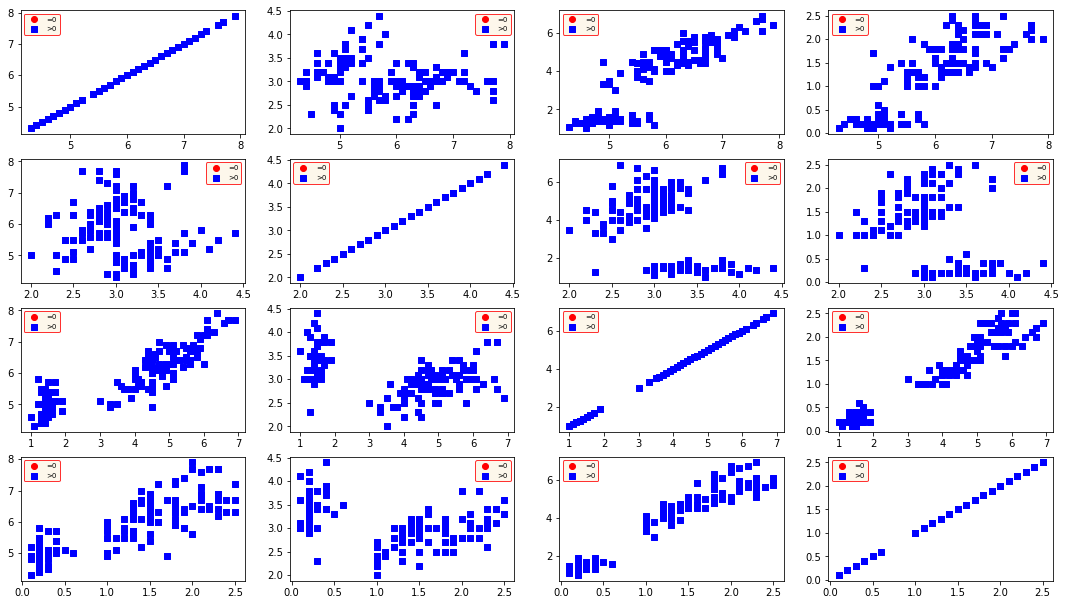

In [125]:
model.increase_gams(1)
print(model.gams)
calc_accuracy_with_predictions(model=model, X=testX, Y=testY)

fig, axs = plt.subplots(nrows=4, ncols=4)

colors = ['red', 'blue', 'green']
test_colors = ['purple', 'black', 'yellow']

gams = model.gams

for i in range(4):
    for j in range(4):
            axs[i%4, j%4].scatter(trainX[np.where(gams== 0)[0], i], trainX[np.where(gams== 0)[0], j], color = colors[0], label='=0')
            axs[i%4, j%4].scatter(trainX[np.where(gams!= 0)[0], i], trainX[np.where(gams!= 0)[0], j], color = colors[1], label='>0', marker='s')
            axs[i%4, j%4].legend(fontsize=7, ncol=1, facecolor='oldlace', edgecolor='r')
fig.set_size_inches(18.5, 10.5)
plt.show()
plt.close()